In [2]:
from PIL import Image, ImageFilter
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import numpy as np

# Folder paths
folder_path_cancer = './dataset/BrainTumorDataSet/Brain Tumor'
folder_path_healthy = './dataset/BrainTumorDataSet/Healthy'

def normalize_features(features):
    normalized_features = []
    for feature in features:
        # Convert pixel values to the range of 0 to 1
        normalized_feature = feature / 255.0
        normalized_features.append(normalized_feature)
    return normalized_features

def load_images_as_features(folder_path, target_size=(224, 224)):
    image_features = []
    # Traverse through files in the folder
    for filename in os.listdir(folder_path):
        # Make sure the file is an image file
        if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.tif', '.tiff')):
            # Open the image file using PIL library
            img = Image.open(os.path.join(folder_path, filename))
                # Convert the image to grayscale and resize it
            if img.mode == 'RGB':
                img_resized = img.resize(target_size, Image.LANCZOS)
                image_features.append(np.array(img_resized))
    
    # Normalize grayscale features
    normalized_features = normalize_features(image_features)
    return normalized_features

# Read and convert cancer images under the cancer label to grayscale features (resize to 224x224)
normalized_cancer_features = load_images_as_features(folder_path_cancer)

# Read and convert non-cancer images under the healthy label to grayscale features (resize to 224x224)
normalized_healthy_features = load_images_as_features(folder_path_healthy)

# Print the number of normalized grayscale features read
print(f"Number of normalized grayscale features under the cancer label: {len(normalized_cancer_features)}")
print(f"Number of normalized grayscale features under the healthy label: {len(normalized_healthy_features)}")


Number of normalized grayscale features under the cancer label: 2421
Number of normalized grayscale features under the healthy label: 2040


In [3]:
import numpy as np

# Merge the feature lists
features_ = np.array(normalized_cancer_features + normalized_healthy_features)

# Reshape the features dimensions
features = features_.transpose(0, 3, 1, 2)

# Generate the label list, 1 represents tumor, 0 represents non-tumor
num_cancer_images = len(normalized_cancer_features)
num_healthy_images = len(normalized_healthy_features)
labels = np.array([1] * num_cancer_images + [0] * num_healthy_images)

print(f"Number of features: {len(features)}")
print(f"Number of labels: {len(labels)}")


Number of features: 4461
Number of labels: 4461


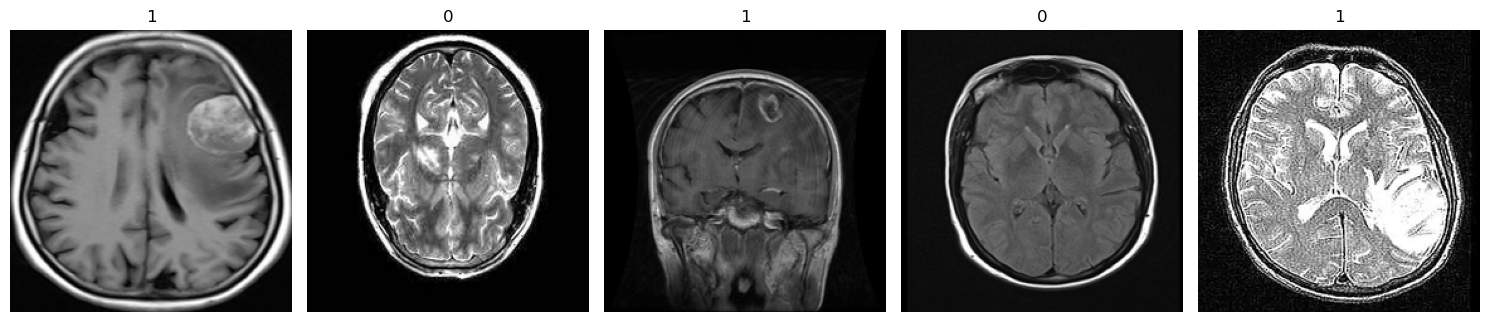

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as n

# Randomly select a few images from features to display
num_images_to_display = 5  # Number of images to display
selected_indices = random.sample(range(len(features_)), num_images_to_display)

# Create a grid for image display
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))

# Display the selected images
for i, idx in enumerate(selected_indices):
    image = features_[idx]  # Get the image feature at the selected
    label = labels[idx]    # Get the label at the selected index
    
    axes[i].imshow(image, cmap='gray')  # Display grayscale image using a grayscale colormap
    axes[i].axis('off')  # Turn off axis display
    axes[i].set_title(label, fontsize=12)
    
plt.tight_layout()
plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        avg_out = self.avg_pool(x).view(x.size(0), -1)
        max_out = self.max_pool(x).view(x.size(0), -1)
        avg_attention = self.fc(avg_out)
        max_attention = self.fc(max_out)
        combined = avg_attention + max_attention
        combined_attention = self.fc(combined).unsqueeze(2).unsqueeze(3)
        return x * combined_attention.expand_as(x)

/home/zhangting/anaconda3/envs/work/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialAttention(nn.Module):
    
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=3,padding=1)  # 3x3 convolution for dimension reduction
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)  # Calculate average
        max_pool, _ = torch.max(x, dim=1, keepdim=True)  # Calculate maximum
        combined = torch.cat([avg_pool, max_pool], dim=1)  # Concatenate average and maximum
        attention = self.conv1(combined)  # Feature integration using 3x3 convolution
        attention = self.sigmoid(attention)  # Apply Sigmoid activation function to obtain attention weights
        return x * attention.expand_as(x)  # Multiply the feature map by the attention weights to obtain weighted features

In [7]:
# First convolutional block (Channel Attention Module)
class ConvBlockWithChannelAttention(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ConvBlockWithChannelAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            ChannelAttention(in_channels=out_channels)  # Use Channel Attention Module
        )

    def forward(self, x):
        return self.conv(x)

# Second convolutional block (Spatial Attention Module)
class ConvBlockWithSpatialAttention(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ConvBlockWithSpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SpatialAttention()  # Use Spatial Attention Module
        )

    def forward(self, x):
        return self.conv(x)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeightedSumModule(nn.Module):
    def __init__(self, in_channels):
        super(WeightedSumModule, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=2, kernel_size=3, padding=1)

    def forward(self, x, y):
        # Concatenated tensor
        concatenated = torch.cat((x, y), dim=1)

        # Convolution operation
        conv_output = self.conv(concatenated)

        # Apply softmax operation to the convolution output, along the second dimension
        softmax_output = F.softmax(conv_output, dim=1)

        # Weighted sum using the obtained weights
        weighted_sum = (softmax_output[:, 0:1] * x) + (softmax_output[:, 1:2] * y)
        
        return weighted_sum

In [9]:
class VGGModule(nn.Module):
    def __init__(self):
        super(VGGModule, self).__init__()
        # Convolutional Network 1 (with Channel Attention Module)
        self.Con1_block1_64 = ConvBlockWithChannelAttention(3, 64, 3, 1)
        self.Con1_block1_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Con1_block2_128 = ConvBlockWithChannelAttention(64, 128, 3, 1)
        self.Con1_block2_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Con1_block3_256 = ConvBlockWithChannelAttention(128, 256, 3, 1)
        self.Con1_block3_max= nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Con1_block4_512 = ConvBlockWithChannelAttention(256, 512, 3, 1)
        self.Con1_block4_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Con1_block5_512 = ConvBlockWithChannelAttention(512, 512, 3, 1)
        self.Con1_block5_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        
        # Convolutional Network 2 (with Spatial Attention Module)
        self.Con2_block1_64 = ConvBlockWithSpatialAttention(3, 64, 3, 1)
        self.Con2_block1_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Con2_block2_128_1 = ConvBlockWithSpatialAttention(64, 128, 3, 1)
        self.Con2_block2_128_2= ConvBlockWithSpatialAttention(128, 128, 3, 1)
        self.Con2_block2_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Con2_block3_256 = ConvBlockWithSpatialAttention(128, 256, 3, 1)
        self.Con2_block3_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Con2_block4_512 = ConvBlockWithSpatialAttention(256, 512, 3, 1)
        self.Con2_block4_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.Con2_block5_512 = ConvBlockWithSpatialAttention(512, 512, 3, 1)
        self.Con2_block5_max = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        # Attention weights for interaction between Convolutional Network 1 and Convolutional Network 2
        self.attention_block1 = WeightedSumModule(64 + 64)
        self.attention_block2 = WeightedSumModule(128 + 128)
        self.attention_block3 = WeightedSumModule(256 + 256)
        self.attention_block4 = WeightedSumModule(512 + 512)
        self.attention_block5 = WeightedSumModule(512 + 512)

        self.mlp = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096,2),
        )

        

    def forward(self, x):
        y1 = self.Con1_block1_64(x)
        y1 = self.Con1_block1_max(y1)
        
        y2 = self.Con2_block1_64(x)
        y2 = self.Con2_block1_max(y2)
        
        # Merge using attention
        x = self.attention_block1(y1,y2)
        
        y1 = self.Con1_block2_128(x)
        y1 = self.Con1_block2_max(y1)
        
        y2 = self.Con2_block2_128_1(x)
        y2 = self.Con2_block2_128_2(y2)
        y2 = self.Con2_block2_max(y2)
        
        # Merge using attention
        x = self.attention_block2(y1,y2)
        
        
        y1 = self.Con1_block3_256(x)
        y1 = self.Con1_block3_max(y1)
        
        y2 = self.Con2_block3_256(x)
        y2 = self.Con2_block3_max(y2)
        
        # Merge using attention
        x = self.attention_block3(y1,y2)
        
        
        y1 = self.Con1_block4_512(x)
        y1 = self.Con1_block4_max(y1)
        
        y2 = self.Con2_block4_512(x)
        y2 = self.Con2_block4_max(y2)
        
        # Merge using attention
        x = self.attention_block4(y1,y2)
        
        y1 = self.Con1_block5_512(x)
        y1 = self.Con1_block5_max(y1)
        
        y2 = self.Con2_block5_512(x)
        y2 = self.Con2_block5_max(y2)
        
        # Merge using attention
        x = self.attention_block5(y1,y2)
        
        #mlp
        x = x.reshape(x.size(0), -1)
        x = self.mlp(x)
        
        return x


# Create an instance of VGG Module
model = VGGModule()

# Create random input data (replace with your own data)
input_data = torch.randn(4, 3, 224, 224)  # # Assuming input is a 3-channel image of size 224x224

# Forward pass the input data through the network
output = model(input_data)
print(output.shape)

torch.Size([4, 2])


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCrossEntropyLoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(CustomCrossEntropyLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, outputs, targets):
        # Calculate softmax probabilities
        stable_outputs = outputs/10  # Stabilize the outputs by dividing them by 10
        probs = F.softmax(stable_outputs, dim=1)
        
        # Prevent NaN by clipping probabilities within a small range
        probs = torch.clamp(probs, min=self.epsilon, max=1.0 - self.epsilon)
        
        # Get predicted probabilities for corresponding labels
        predicted_probs = probs[torch.arange(len(probs)), targets]
        
        # Calculate cross-entropy loss
        loss = -torch.log(predicted_probs)
        return loss.mean()

Training on cuda:0
Epoch 1/100,Train Loss: 1.238981259720666
Val loss: 0.5707269992147174, Val Accuracy: 67.94%, Precision: 71.07, Specificity: 56.22%, Sensitivity: 76.25%, F1 Score: 73.57%
Epoch 2/100,Train Loss: 0.48350733678255764
Val loss: 0.5814419431345803, Val Accuracy: 73.32%, Precision: 73.83, Specificity: 57.84%, Sensitivity: 84.29%, F1 Score: 78.71%
Epoch 3/100,Train Loss: 0.3847816639712879
Val loss: 0.426730568919863, Val Accuracy: 82.96%, Precision: 92.63, Specificity: 91.35%, Sensitivity: 77.01%, F1 Score: 84.10%
Epoch 4/100,Train Loss: 0.3222702025835003
Val loss: 0.3213210574218205, Val Accuracy: 86.55%, Precision: 87.64, Specificity: 82.16%, Sensitivity: 89.66%, F1 Score: 88.64%
Epoch 5/100,Train Loss: 0.2865364740469626
Val loss: 0.3108684079987662, Val Accuracy: 85.65%, Precision: 96.68, Specificity: 96.22%, Sensitivity: 78.16%, F1 Score: 86.44%
Epoch 6/100,Train Loss: 0.24412982604865516
Val loss: 0.3066243657044002, Val Accuracy: 87.44%, Precision: 91.84, Specific

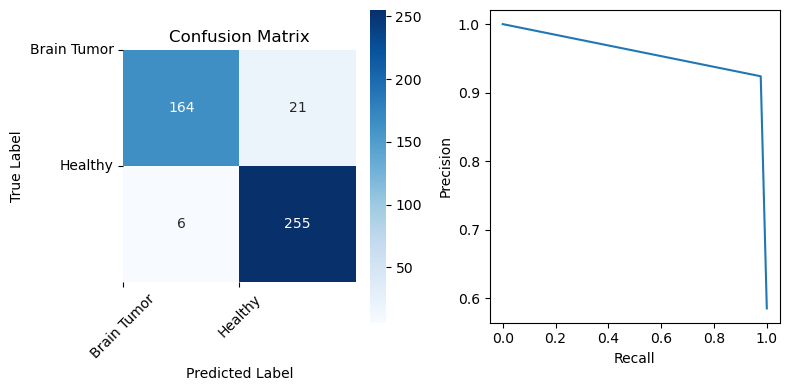

Epoch 11/100,Train Loss: 0.14556262725298957
Val loss: 0.29183697274753023, Val Accuracy: 89.69%, Precision: 97.36, Specificity: 96.76%, Sensitivity: 84.67%, F1 Score: 90.57%
Epoch 12/100,Train Loss: 0.11884445161558688
Val loss: 0.18926470407417842, Val Accuracy: 93.50%, Precision: 94.62, Specificity: 92.43%, Sensitivity: 94.25%, F1 Score: 94.43%
Epoch 13/100,Train Loss: 0.06868430482323415
Val loss: 0.13353831746748515, Val Accuracy: 95.29%, Precision: 96.51, Specificity: 95.14%, Sensitivity: 95.40%, F1 Score: 95.95%
Epoch 14/100,Train Loss: 0.070438006360616
Val loss: 0.15060482919216156, Val Accuracy: 94.62%, Precision: 95.75, Specificity: 94.05%, Sensitivity: 95.02%, F1 Score: 95.38%
Epoch 15/100,Train Loss: 0.07919282261614821
Val loss: 0.4567662647792271, Val Accuracy: 85.20%, Precision: 98.51, Specificity: 98.38%, Sensitivity: 75.86%, F1 Score: 85.71%
Epoch 16/100,Train Loss: 0.07163041605547603
Val loss: 0.1245068008346217, Val Accuracy: 95.74%, Precision: 97.27, Specificity: 

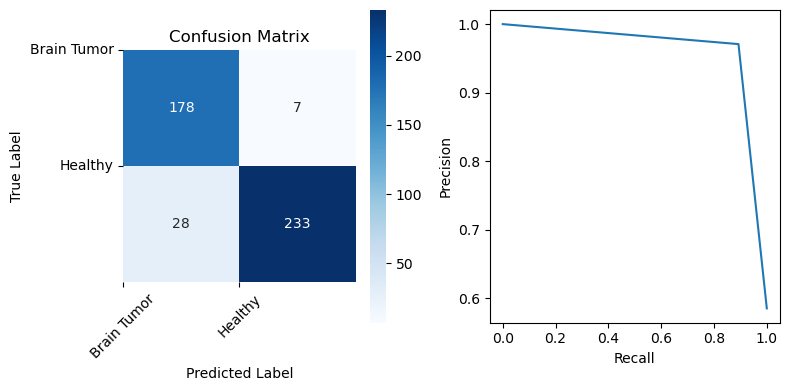

Epoch 21/100,Train Loss: 0.04094530086981
Val loss: 0.13533503508993558, Val Accuracy: 96.64%, Precision: 95.56, Specificity: 93.51%, Sensitivity: 98.85%, F1 Score: 97.18%
Epoch 22/100,Train Loss: 0.03813684991161738
Val loss: 0.16497684030660562, Val Accuracy: 95.52%, Precision: 95.47, Specificity: 93.51%, Sensitivity: 96.93%, F1 Score: 96.20%
Epoch 23/100,Train Loss: 0.04631054880779369
Val loss: 0.16086348997695105, Val Accuracy: 95.29%, Precision: 98.00, Specificity: 97.30%, Sensitivity: 93.87%, F1 Score: 95.89%
Epoch 24/100,Train Loss: 0.027649499521690553
Val loss: 0.15688709101440118, Val Accuracy: 96.41%, Precision: 95.20, Specificity: 92.97%, Sensitivity: 98.85%, F1 Score: 96.99%
Epoch 25/100,Train Loss: 0.016550507875113647
Val loss: 0.17366609509502137, Val Accuracy: 95.96%, Precision: 96.20, Specificity: 94.59%, Sensitivity: 96.93%, F1 Score: 96.56%
Epoch 26/100,Train Loss: 0.03260954721918097
Val loss: 0.1717700298343386, Val Accuracy: 95.29%, Precision: 96.88, Specificity

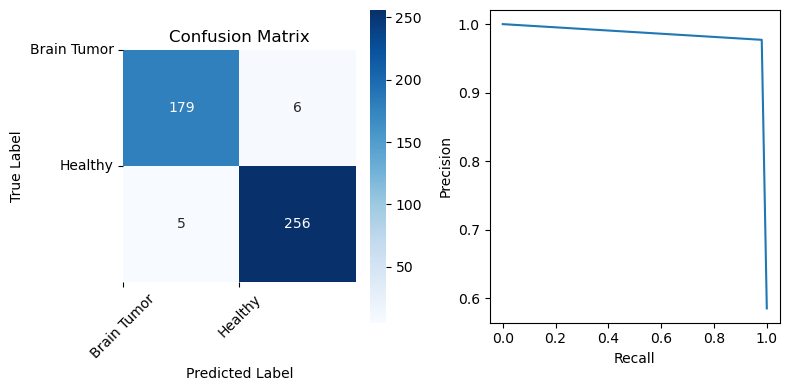

Epoch 31/100,Train Loss: 0.031376603927388454
Val loss: 0.17844409389155252, Val Accuracy: 95.29%, Precision: 98.39, Specificity: 97.84%, Sensitivity: 93.49%, F1 Score: 95.87%
Epoch 32/100,Train Loss: 0.05414637168204146
Val loss: 0.15545547008514404, Val Accuracy: 95.52%, Precision: 95.13, Specificity: 92.97%, Sensitivity: 97.32%, F1 Score: 96.21%
Epoch 33/100,Train Loss: 0.03924855905851083
Val loss: 0.1262960808484682, Val Accuracy: 97.09%, Precision: 96.62, Specificity: 95.14%, Sensitivity: 98.47%, F1 Score: 97.53%
Epoch 34/100,Train Loss: 0.027191415952984244
Val loss: 0.11749783158302307, Val Accuracy: 97.31%, Precision: 97.34, Specificity: 96.22%, Sensitivity: 98.08%, F1 Score: 97.71%
Epoch 35/100,Train Loss: 0.020834666024061983
Val loss: 0.12815333171082394, Val Accuracy: 95.29%, Precision: 98.00, Specificity: 97.30%, Sensitivity: 93.87%, F1 Score: 95.89%
Epoch 36/100,Train Loss: 0.015919626924317396
Val loss: 0.22448736961398805, Val Accuracy: 94.84%, Precision: 96.12, Specif

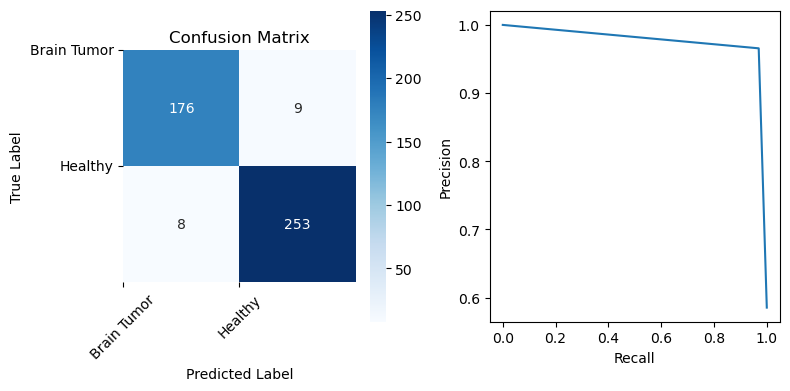

Epoch 41/100,Train Loss: 0.011200723356718558
Val loss: 0.11790999211370945, Val Accuracy: 96.86%, Precision: 98.05, Specificity: 97.30%, Sensitivity: 96.55%, F1 Score: 97.30%
Epoch 42/100,Train Loss: 0.04765185664083609
Val loss: 0.12974868076188223, Val Accuracy: 96.19%, Precision: 98.03, Specificity: 97.30%, Sensitivity: 95.40%, F1 Score: 96.70%
Epoch 43/100,Train Loss: 0.010821405090350058
Val loss: 0.12600982721362794, Val Accuracy: 95.74%, Precision: 97.64, Specificity: 96.76%, Sensitivity: 95.02%, F1 Score: 96.31%
Epoch 44/100,Train Loss: 0.004883515743391139
Val loss: 0.11900530954257452, Val Accuracy: 97.09%, Precision: 97.33, Specificity: 96.22%, Sensitivity: 97.70%, F1 Score: 97.51%
Epoch 45/100,Train Loss: 0.014162572808540322
Val loss: 0.19414620952946798, Val Accuracy: 95.74%, Precision: 94.49, Specificity: 91.89%, Sensitivity: 98.47%, F1 Score: 96.44%
Epoch 46/100,Train Loss: 0.03007618773179794
Val loss: 0.10195932520686515, Val Accuracy: 97.76%, Precision: 98.08, Speci

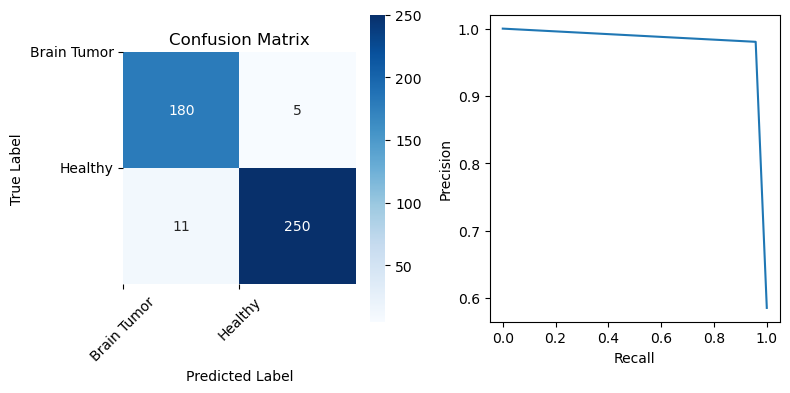

Epoch 51/100,Train Loss: 0.0055403975722064
Val loss: 0.18854006361548922, Val Accuracy: 96.86%, Precision: 98.43, Specificity: 97.84%, Sensitivity: 96.17%, F1 Score: 97.29%
Epoch 52/100,Train Loss: 0.007233703033161224
Val loss: 0.1578446140795547, Val Accuracy: 98.21%, Precision: 97.74, Specificity: 96.76%, Sensitivity: 99.23%, F1 Score: 98.48%
Epoch 53/100,Train Loss: 0.00508171930719722
Val loss: 0.16086109913885593, Val Accuracy: 97.09%, Precision: 98.44, Specificity: 97.84%, Sensitivity: 96.55%, F1 Score: 97.49%
Epoch 54/100,Train Loss: 0.005465551335743969
Val loss: 0.21421224045168077, Val Accuracy: 97.09%, Precision: 98.06, Specificity: 97.30%, Sensitivity: 96.93%, F1 Score: 97.50%
Epoch 55/100,Train Loss: 0.010604359237504468
Val loss: 0.1543076347027506, Val Accuracy: 97.53%, Precision: 97.35, Specificity: 96.22%, Sensitivity: 98.47%, F1 Score: 97.90%
Epoch 56/100,Train Loss: 0.012060640065361181
Val loss: 0.2209052658373756, Val Accuracy: 97.09%, Precision: 96.27, Specifici

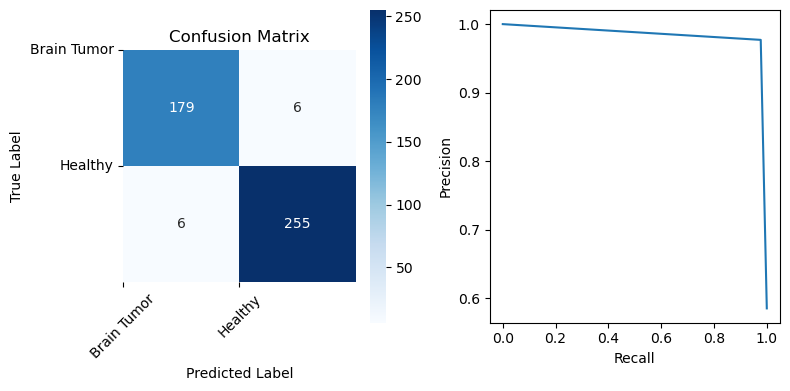

Epoch 61/100,Train Loss: 0.010798311058968986
Val loss: 0.1715430143355791, Val Accuracy: 97.31%, Precision: 98.07, Specificity: 97.30%, Sensitivity: 97.32%, F1 Score: 97.69%
Epoch 62/100,Train Loss: 0.004846532855741056
Val loss: 0.20235910284723754, Val Accuracy: 96.64%, Precision: 97.67, Specificity: 96.76%, Sensitivity: 96.55%, F1 Score: 97.11%
Epoch 63/100,Train Loss: 0.01748462990141369
Val loss: 0.12003839734409537, Val Accuracy: 96.86%, Precision: 98.05, Specificity: 97.30%, Sensitivity: 96.55%, F1 Score: 97.30%
Epoch 64/100,Train Loss: 0.030643768284010418
Val loss: 0.12852185086480208, Val Accuracy: 96.41%, Precision: 98.04, Specificity: 97.30%, Sensitivity: 95.79%, F1 Score: 96.90%
Epoch 65/100,Train Loss: 0.019558350730351646
Val loss: 0.11868638136158031, Val Accuracy: 97.53%, Precision: 96.64, Specificity: 95.14%, Sensitivity: 99.23%, F1 Score: 97.92%
Epoch 66/100,Train Loss: 0.009414983149002052
Val loss: 0.17138842679560184, Val Accuracy: 97.09%, Precision: 98.44, Speci

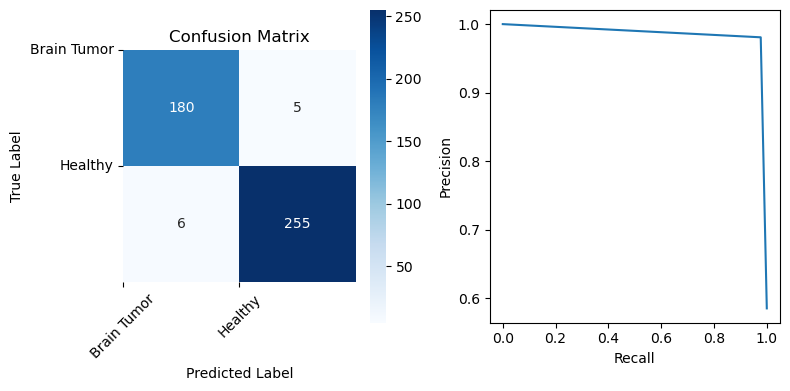

Epoch 71/100,Train Loss: 0.00535458356605188
Val loss: 0.149159888678696, Val Accuracy: 97.53%, Precision: 97.71, Specificity: 96.76%, Sensitivity: 98.08%, F1 Score: 97.90%
Epoch 72/100,Train Loss: 0.0010771615990928954
Val loss: 0.18989426655960934, Val Accuracy: 97.09%, Precision: 97.69, Specificity: 96.76%, Sensitivity: 97.32%, F1 Score: 97.50%
Epoch 73/100,Train Loss: 0.0024881604186199574
Val loss: 0.23932337915175594, Val Accuracy: 96.86%, Precision: 96.96, Specificity: 95.68%, Sensitivity: 97.70%, F1 Score: 97.33%
Epoch 74/100,Train Loss: 0.00554800830291364
Val loss: 0.2333208569658122, Val Accuracy: 96.86%, Precision: 96.96, Specificity: 95.68%, Sensitivity: 97.70%, F1 Score: 97.33%
Epoch 75/100,Train Loss: 0.007068966284334367
Val loss: 0.35872976162603926, Val Accuracy: 94.62%, Precision: 97.98, Specificity: 97.30%, Sensitivity: 92.72%, F1 Score: 95.28%
Epoch 76/100,Train Loss: 0.11275517130138724
Val loss: 0.15190015932811157, Val Accuracy: 96.19%, Precision: 96.21, Specifi

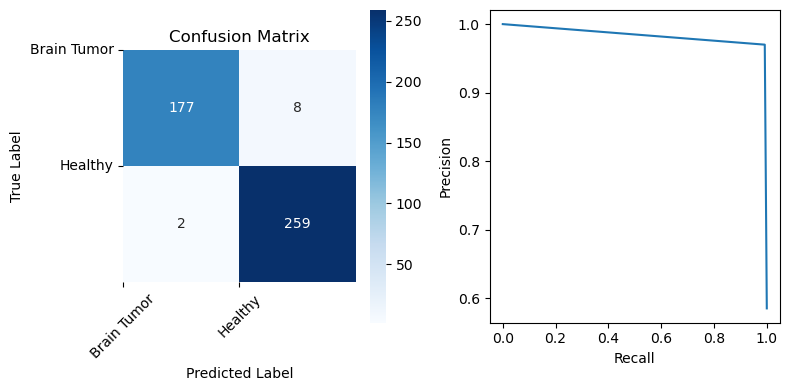

Epoch 81/100,Train Loss: 0.005818979367144753
Val loss: 0.1067128231017185, Val Accuracy: 97.76%, Precision: 97.72, Specificity: 96.76%, Sensitivity: 98.47%, F1 Score: 98.09%
Epoch 82/100,Train Loss: 0.0029612941248485314
Val loss: 0.1096670496065469, Val Accuracy: 98.21%, Precision: 98.47, Specificity: 97.84%, Sensitivity: 98.47%, F1 Score: 98.47%
Epoch 83/100,Train Loss: 0.007839839003833862
Val loss: 0.21877069844465172, Val Accuracy: 95.52%, Precision: 93.19, Specificity: 89.73%, Sensitivity: 99.62%, F1 Score: 96.30%
Epoch 84/100,Train Loss: 0.019889937890963796
Val loss: 0.16791795194149017, Val Accuracy: 96.86%, Precision: 98.43, Specificity: 97.84%, Sensitivity: 96.17%, F1 Score: 97.29%
Epoch 85/100,Train Loss: 0.010473105397198066
Val loss: 0.1672423133360488, Val Accuracy: 97.76%, Precision: 97.72, Specificity: 96.76%, Sensitivity: 98.47%, F1 Score: 98.09%
Epoch 86/100,Train Loss: 0.007989649331632011
Val loss: 0.20773514147315705, Val Accuracy: 96.19%, Precision: 95.86, Speci

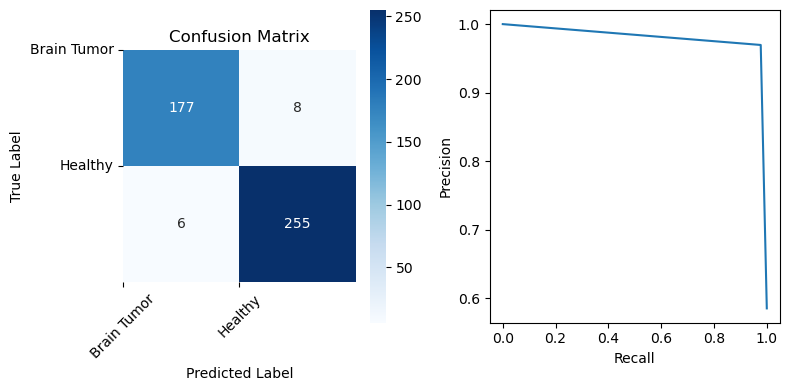

Epoch 91/100,Train Loss: 0.012941426975430659
Val loss: 0.17261948330061777, Val Accuracy: 97.31%, Precision: 98.07, Specificity: 97.30%, Sensitivity: 97.32%, F1 Score: 97.69%
Epoch 92/100,Train Loss: 0.007645977795570096
Val loss: 0.13817016507631966, Val Accuracy: 97.31%, Precision: 98.07, Specificity: 97.30%, Sensitivity: 97.32%, F1 Score: 97.69%
Epoch 93/100,Train Loss: 0.0018725942800342313
Val loss: 0.16256770834193698, Val Accuracy: 97.53%, Precision: 98.08, Specificity: 97.30%, Sensitivity: 97.70%, F1 Score: 97.89%
Epoch 94/100,Train Loss: 0.0017160794547064842
Val loss: 0.12983371490346535, Val Accuracy: 97.98%, Precision: 98.09, Specificity: 97.30%, Sensitivity: 98.47%, F1 Score: 98.28%
Epoch 95/100,Train Loss: 0.0003057142701123894
Val loss: 0.13451248322547013, Val Accuracy: 97.76%, Precision: 99.22, Specificity: 98.92%, Sensitivity: 96.93%, F1 Score: 98.06%
Epoch 96/100,Train Loss: 0.0016849052076760732
Val loss: 0.2226530143192836, Val Accuracy: 97.31%, Precision: 97.70, 

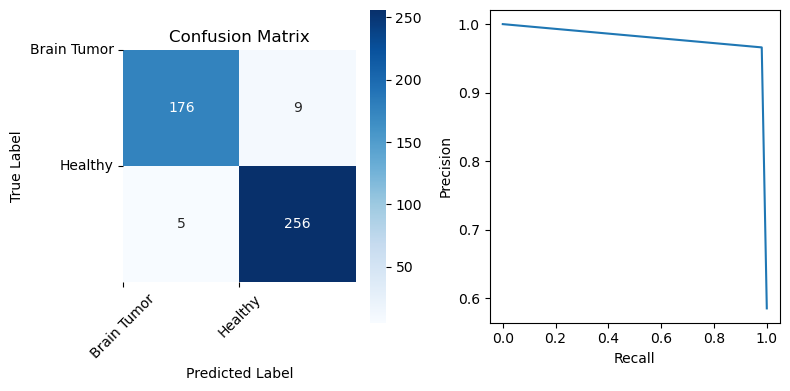

Training finished!
cost_time:  2187.92480635643


In [20]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init
from sklearn.metrics import  confusion_matrix, roc_curve, precision_recall_curve
import seaborn as sns
import time





def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Compute the loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        print(f"Epoch {epoch + 1}/{num_epochs},Train Loss: {running_loss / len(train_loader)}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        # New evaluation metrics variables added
        total_intersection = 0
        total_union = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                
                # Compute confusion matrix statistics for evaluation metrics
                # Compute mIoU and Dice Score
                # intersection = (predicted & labels).sum().item()
                # union = (predicted | labels).sum().item()

                # total_intersection += intersection
                # total_union += union

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
        
        TP = 0
        FP = 0
        TN = 0
        FN = 0
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)

        # print(all_preds == 1)
        # print(all_labels == 1)
        # print(((all_preds == 1) & (all_labels == 1)))
        TP = ((all_preds == 1) & (all_labels == 1)).sum().item()
        FP = ((all_preds == 1) & (all_labels == 0)).sum().item()
        TN = ((all_preds == 0) & (all_labels == 0)).sum().item()
        FN = ((all_preds == 0) & (all_labels == 1)).sum().item()

        # Compute evaluation metrics
        accuracy = 100 * (TP + TN) / (TP + FP + TN + FN)
        specificity = 100 * TN / (TN + FP)
        sensitivity = 100 * TP / (TP + FN)
        f1_score =100 * 2 * TP / (2 * TP + FP + FN)
        # mIoU = 100 * total_intersection / total_union
        precision = 100 * TP / (TP + FP)
        # dice_score =100 * 2 * total_intersection / (total_union + total_intersection)
        print(f"Val loss: {val_loss / len(val_loader)}, Val Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}, Specificity: {specificity:.2f}%, Sensitivity: {sensitivity:.2f}%, F1 Score: {f1_score:.2f}%")
        # print(all_labels)
        # print(all_preds)
        if (epoch+1) % 10 == 0:
            cm = confusion_matrix(all_labels,all_preds)
            p, r, thresholds = precision_recall_curve(all_labels, all_preds)
            
            # Plot training loss curve
            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title('Confusion Matrix')

            # Set tick labels
            tick_labels = ['Brain Tumor', 'Healthy']
            plt.xticks([0, 1], tick_labels, rotation=45)
            plt.yticks([0, 1], tick_labels, rotation=0)

            plt.subplot(1, 2, 2)
            plt.plot(r, p)
            plt.xlabel('Recall')
            plt.ylabel('Precision') 
            plt.tight_layout()
            plt.show()
        model.train()

    print("Training finished!")



# Split the dataset into training set (80%), validation set (10%), and test set (10%)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)
val_features, test_features, val_labels, test_labels = train_test_split(test_features, test_labels, test_size=0.5, random_state=42)

# Convert features and labels to PyTorch tensors
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)  # # Assuming labels for a classification task, use long type
val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset objects
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)

# Create TensorDataset objects
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Training set DataLoader
val_loader = DataLoader(val_dataset, batch_size=batch_size)  # Validation set DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size)  # Test set DataLoader


# Create the model
model = VGGModule()  # Assuming your model is VGGModule
# Initialize the model parameters
for param in model.parameters():
    if param.dim() > 1:  # Initialize only parameters with dimensions greater than 1
        init.xavier_uniform_(param)  # Use Xavier/Glorot initialization

# Define the loss function and optimizer
criterion = CustomCrossEntropyLoss()  # Use cross-entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)


start_time = time.time()
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)
end_time = time.time()
cost_time = end_time - start_time
print("cost_time: ", cost_time)

In [ ]:
# Validate using Lime

from lime.lime_image import LimeImageExplainer
from torchvision import models
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io
from skimage.segmentation import mark_boundaries
import random

model.eval()

# Create an instance of the LIME explainer
explainer = LimeImageExplainer()

# Define a function to probabilize the model's output and return the probability value from the prediction
def model_predict(images):
    images = images.transpose(0, 3, 1, 2)
    images = torch.tensor(images, dtype=torch.float32).to("cuda")
    outputs = model(images)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.detach().cpu().numpy()

# Randomly select 10 images for explanation
num_images_to_explain = 10
random_indices = random.sample(range(len(features)), num_images_to_explain)

num_rows = (num_images_to_explain + 4) // 5  # Determine the number of rows

fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))  # Create a grid of subplots

for i, idx in enumerate(random_indices):
    row = i // 5
    col = i % 5

    image = features[idx].transpose(1, 2, 0)  # Convert the image to a NumPy array

    # Explain the image using LIME
    explanation = explainer.explain_instance(
        image,
        model_predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    # Get the explanation result
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    # Display the explanation result in the subplot
    axs[row, col].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    axs[row, col].axis('off')  # Turn off the axis

# Handle any excess subplot positions
for i in range(num_images_to_explain, num_rows * 5):
    row = i // 5
    col = i % 5
    axs[row, col].axis('off')  # Turn off the axis for excess subplots
    axs[row, col].set_visible(False)  # Set the excess subplots to invisible

plt.tight_layout()
plt.show()

In [ ]:
#Test function

def test(model, test_loader, criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Testing on {device}")

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_labels).item()
            
            # Calculate test accuracy
            _, predicted_test = torch.max(test_outputs, 1)
            total_test += test_labels.size(0)
            correct_test += (predicted_test == test_labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {test_loss / len(test_loader)}, Test Accuracy: {test_accuracy:.2f}%")

    
    
    
# Call the test function
test(model, test_loader, criterion)

In [ ]:
# Learning Rate Hyperparameter Code
def train_model_with_lr(model, train_loader, val_loader, criterion, optimizer, lr, num_epochs=20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device} with learning rate: {lr}")

    model.to(device)
    model.train()
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                
                _, predicted_val = torch.max(val_outputs, 1)
                total_val += val_labels.size(0)
                correct_val += (predicted_val == val_labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)
        model.train()

    print("Training finished!")
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train with different learning rates
learning_rates = [0.001, 0.01, 0.1]  # Different learning rates to try
batch_size = 64
results = {}

for lr in learning_rates:
    model = VGGModule() # Assuming your model is VGGModule
    for param in model.parameters():
        if param.dim() > 1:
            init.xavier_uniform_(param)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_lr(
        model, train_loader, val_loader, criterion, optimizer, lr, num_epochs=30
    )

    results[lr] = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# Plot loss and accuracy curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
for lr, result in results.items():
    plt.plot(result['train_losses'], label=f'Train LR={lr}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
for lr, result in results.items():
    plt.plot(result['val_accuracies'], label=f'Val LR={lr}')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()